In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dfMovies = pd.read_csv(
    "content/IMDb movies w top_actor, top_actor_gender.csv", dtype={"year": str, "budget": str}, sep="\t"
)
dfNames = pd.read_csv("content/IMDb names.csv")
dfRatings = pd.read_csv("content/IMDb ratings.csv")
dfTitlePrincipals = pd.read_csv("content/IMDb title_principals.csv")

# just run this cell once to load data into memory

In [48]:
# Pick the columns from each of the datasets that should be used to train the ML algorithms
dfMovies = dfMovies[
    [
        "imdb_title_id",
        "title",
        "year",
        "genre",
        "duration",
        "country",
        "language",
        "director",
        "writer",
        "production_company",
        "budget"
    ]
]
dfNames = dfNames[["imdb_name_id", "name"]]
dfRatings = dfRatings[
    ["imdb_title_id", "weighted_average_vote"]
]  # come back to this and include age groups/male/female votes
dfTitlePrincipals = dfTitlePrincipals[
    ["imdb_title_id", "ordering", "imdb_name_id"]
]  # should we get category? "actress"/"actor" (dont know if its necessary)


dfMovies = pd.merge(dfMovies, dfRatings, on=["imdb_title_id"])

dfMovies["year"] = dfMovies["year"].astype(str)

In [49]:
# Preprocess the data
dfMovies.year = dfMovies.year.str.extract("(\d+)")
dfMovies.budget = dfMovies.budget.str.extract("(\d+)")


dfMovies.year = pd.to_numeric(dfMovies.year, errors="coerce").astype("Int64")
dfMovies.budget = pd.to_numeric(dfMovies.budget, errors="coerce").astype("Int64")


df = (
    dfMovies.dropna()
)  # remove rows with NAN - mainly coming from columns 'budget' and 'worlwide_gross_income'

print(df.shape)

(22623, 14)


In [50]:
# Perform generic one hot encoding
def listEncode(df, col):
    if type(col) != list:
        col = [col]

    toEncode = df[col[0]]
    for element in range(1, len(col)):
        toEncode += ", " + df[col[element]]
    one_hot = toEncode.str.get_dummies(sep=", ")
    print(one_hot)
    df = df.drop(col, axis=1)
    df = df.join(one_hot)
    return df


moviesToEncode = ["genre", "country", "language"]
df = listEncode(df, moviesToEncode)

One Hot Encoding on Many Categorical Values

Some other columns need to be one hot encoded. These columns, however, have many unique values. To deal with this, we will only one hot encode the top X values present in each column. To find out the best value for X, the data needs to visualized, as seen below.

In [51]:
# Perform generic one hot encoding 
def TopNCategoriesCounts(df, col, min_val): # find the value counts for each value in the col that have values above the min_val
    df = df.copy()
    value_counts = {}
    for row in range(len(df[col])):
        element_string = df.iloc[row][col] # obtain the element containing comma separated values
        elements = element_string.split(", ")
        for element in elements: #update value counts
            if element in value_counts:
                value_counts[element] += 1
            else:
                value_counts[element] = 1
    sorted_counts = {}
    for key, value in sorted(value_counts.items(), key=lambda x: x[1], reverse=True): # sort the dict and filter out those that don't meet the min value
        if value >= min_val:
            sorted_counts[key] = value   

    return sorted_counts


def encodeTopNCategories(df, col, sorted_counts, min_val): # returns one hot encoded df of the col based on the keys in sorted_counts that have values above the min_val
    df = df.copy()
    
    encode_counts = {}
    for key, value in sorted_counts.items(): # filter out the values with counts that dont meet the threshold
        if value >= min_val:
            encode_counts[key] = value
    keys = list(encode_counts) # create a list of the keys to be included in the one hot encoding
    df[col] = df.apply(lambda row: ", ".join([element for element in row[col].split(", ") if element in keys]), axis=1) # filter out elements that are not being included in one hot encoding
    one_hot = df[col].str.get_dummies(sep=', ') # one hot encode
    df = df.drop(col,axis = 1) # remove old column
    other_col = one_hot.eq(0).all(axis=1).astype(int) # generate a new  'other' column if all the one hot encoded columns are 0
    one_hot[col + '_other'] = other_col
    df = pd.concat([df, one_hot], axis=1)

    return df

In [52]:
print("Director results:")

sorted_director_counts = TopNCategoriesCounts(df, "director", 1)

for num_directors in range(1, 21):
    sorted_directors = {}
    for key, value in sorted_director_counts.items():
        if value >= num_directors:
            sorted_directors[key] = value
    num_unique_directors = len(list(sorted_directors))
    print(
        "Number of Directors appearing in "
        + str(num_directors)
        + " or more movies: "
        + str(num_unique_directors)
    )
print()

sorted_writer_counts = TopNCategoriesCounts(df, "writer", 1)

for num_writers in range(1, 21):
    sorted_writers = {}
    for key, value in sorted_writer_counts.items():
        if value >= num_writers:
            sorted_writers[key] = value
    num_unique_writers = len(list(sorted_writers))
    print(
        "Number of Writers appearing in "
        + str(num_writers)
        + " or more movies: "
        + str(num_unique_writers)
    )
print()

sorted_company_counts = TopNCategoriesCounts(df, "production_company", 1)

for num_companies in range(1, 21):
    sorted_companies = {}
    for key, value in sorted_company_counts.items():
        if value >= num_companies:
            sorted_companies[key] = value
    num_unique_companies = len(list(sorted_companies))
    print(
        "Number of Companies in "
        + str(num_companies)
        + " or more movies: "
        + str(num_unique_companies)
    )

Director results:
Number of Directors appearing in 1 or more movies: 12787
Number of Directors appearing in 2 or more movies: 4090
Number of Directors appearing in 3 or more movies: 2138
Number of Directors appearing in 4 or more movies: 1300
Number of Directors appearing in 5 or more movies: 886
Number of Directors appearing in 6 or more movies: 629
Number of Directors appearing in 7 or more movies: 477
Number of Directors appearing in 8 or more movies: 362
Number of Directors appearing in 9 or more movies: 294
Number of Directors appearing in 10 or more movies: 235
Number of Directors appearing in 11 or more movies: 187
Number of Directors appearing in 12 or more movies: 151
Number of Directors appearing in 13 or more movies: 124
Number of Directors appearing in 14 or more movies: 100
Number of Directors appearing in 15 or more movies: 82
Number of Directors appearing in 16 or more movies: 72
Number of Directors appearing in 17 or more movies: 61
Number of Directors appearing in 18 o

Based on the outcome, it is evident that there are a lot of unique values for directors, writers and production companies that appear in more than 1 movies, 2 movies, and so on. So it doesn't make sense to one hot encode this many new columns for each of these columns as it gives limited information to train the model on with an expensive time complexity cost. 

So to obtain as much information as possible while limiting the increasing complexity of the number of the columns...

The number of director values to one hot encode for those appearing in more than 10 movies will be 80.

The number of writer values to one hot encode for those appearing in more than 4 movies will be 77.

The number of production companies to one hot encode for those appearing in more than 10 movies will be 95.


A Bar plot of these results is shown below:

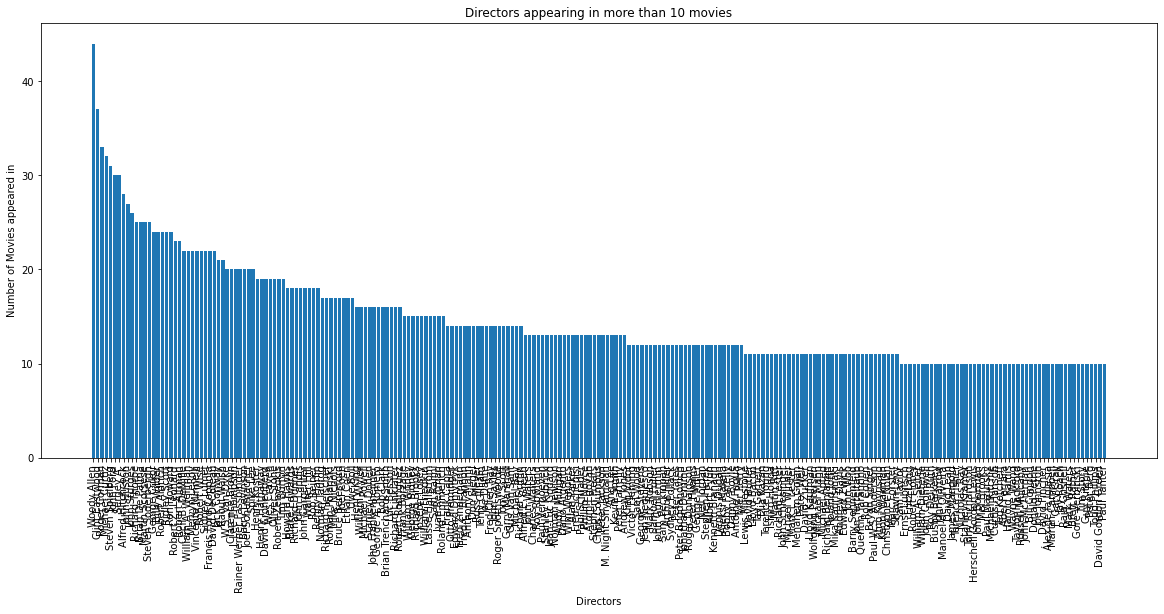

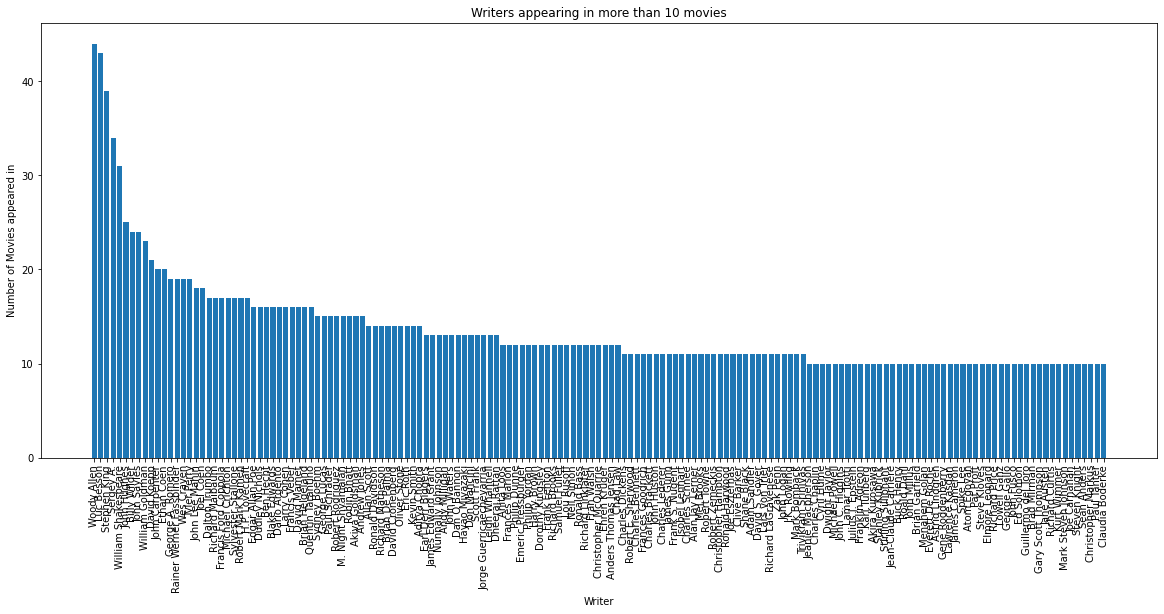

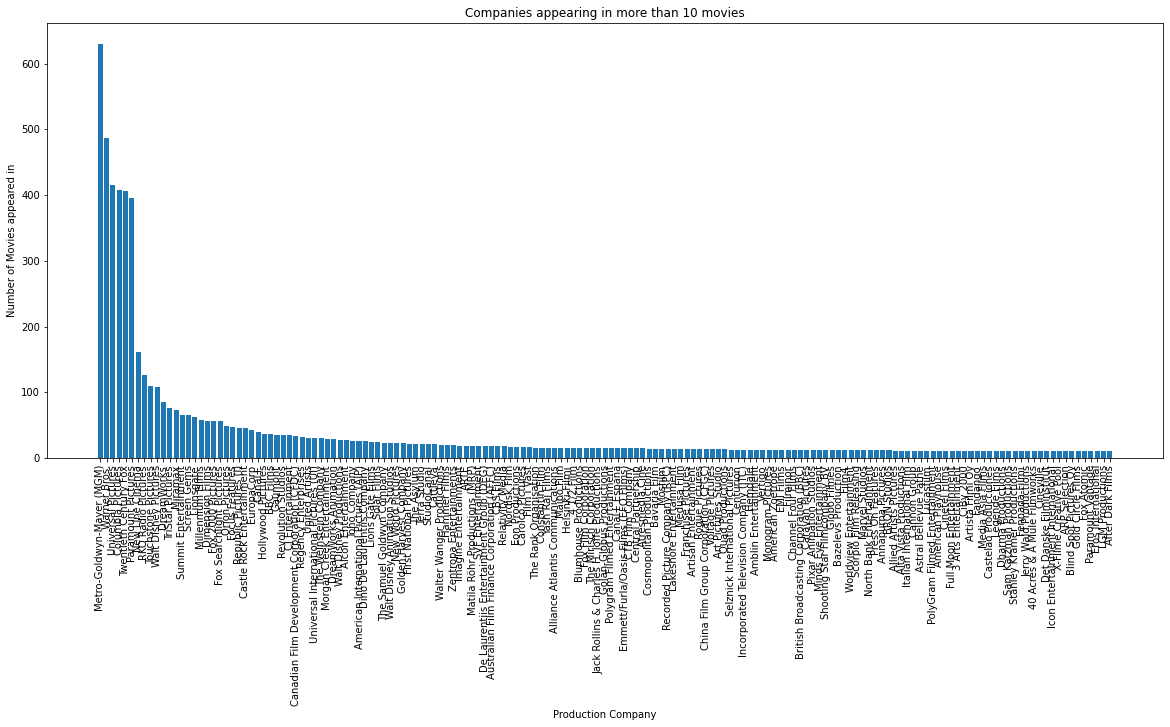

In [53]:
import matplotlib.pyplot as plt

# EDA Visualization of Directors and Writers
director_counts_10 = {}
for key, value in sorted_director_counts.items():
    if value >= 10:
        director_counts_10[key] = value

plt.figure(figsize=(20, 8))
plt.title("Directors appearing in more than 10 movies")
plt.xlabel("Directors")
plt.ylabel("Number of Movies appeared in")
plt.xticks(rotation="vertical")
plt.bar(director_counts_10.keys(), director_counts_10.values())
plt.show()

writer_counts_10 = {}
for key, value in sorted_writer_counts.items():
    if value >= 10:
        writer_counts_10[key] = value

plt.figure(figsize=(20, 8))
plt.title("Writers appearing in more than 10 movies")
plt.xlabel("Writer")
plt.ylabel("Number of Movies appeared in")
plt.xticks(rotation="vertical")
plt.bar(writer_counts_10.keys(), writer_counts_10.values())
plt.show()

company_counts_10 = {}
for key, value in sorted_company_counts.items():
    if value >= 10:
        company_counts_10[key] = value

plt.figure(figsize=(20, 8))
plt.title("Companies appearing in more than 10 movies")
plt.xlabel("Production Company")
plt.ylabel("Number of Movies appeared in")
plt.xticks(rotation="vertical")
plt.bar(company_counts_10.keys(), company_counts_10.values())
plt.show()

In [54]:
one_hot_encoded_df = df

one_hot_encoded_df = encodeTopNCategories(
    one_hot_encoded_df, "director", sorted_director_counts, 10
)  # one hot encode top 100 directors only
one_hot_encoded_df = encodeTopNCategories(
    one_hot_encoded_df, "writer", sorted_writer_counts, 10
)  # one hot encode top 100 writers only
one_hot_encoded_df = encodeTopNCategories(
    one_hot_encoded_df, "production_company", sorted_company_counts, 10
)  # one hot encode top 100 writers only

print(one_hot_encoded_df.shape)
# output to a csv
one_hot_encoded_df.to_csv("content/combined_data.csv", index=False)